### Optimal Control on Simple Systems: Driven JC Model

In [3]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from jaxpulse.controllers import ControlVector, SinusoidalControl, ConstantControl, FrequencyControl, GaussianControl, GaussianPulseTrain
from jaxpulse.optimizers import ClosedQuantumSystem, OpenQuantumSystem, OptimalController
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### System Setup

In [4]:
N_res = 4
N_qub = 2
omega_res = 3.0
omega_qub = 2.2
g = .1

a = dq.tensor(dq.destroy(N_res), dq.eye(N_qub))
b = dq.tensor(dq.eye(N_res), dq.destroy(N_qub))
Z = dq.tensor(dq.eye(N_res), dq.number(N_qub))
H_0 = omega_res * dq.dag(a)@a + omega_qub * dq.dag(b)@b # static Hamiltonian
H_1 = dq.dag(a) @ b + a @ dq.dag(b) # coupling
H_2 = 1./jnp.sqrt(2)*(a + dq.dag(a)) # X
H_3 = 1j/jnp.sqrt(2)*(dq.dag(a) - a) # P
H_M = [H_1, H_2]
psi_0 = dq.tensor(dq.fock(N_res,0),dq.fock(N_qub,0))


#### Control Setups

In [5]:
coupling_control = GaussianControl(
    amp=jnp.array([1.0, 1.0]),
    mean=jnp.array([5.0, 10.0]),
    sigma=jnp.array([1.0, 1.0])
)
drive_X = GaussianControl(
    amp=jnp.ones((4,)),
    mean=jnp.linspace(2,12,4),
    sigma=jnp.ones((4,))
)
drive_X = GaussianPulseTrain(
    amp =jnp.array([1.0]),
    mean=jnp.array([4.0]),
    sigma=jnp.array([.5]),
    period=jnp.array([6.0])
)

#### Optimizer Setup

In [6]:
jc_system = ClosedQuantumSystem(
    H_0=H_0,
    H_M=H_M
)

jc_controls = ControlVector(
    [
        coupling_control,
        drive_X,
    ]
)

def final_penalty(psi_tF: Array) -> float:
    return 1 - dq.expect(Z, psi_tF)

duration= 15.0
controller = OptimalController(
    system=jc_system,
    controls=jc_controls,
    y0=psi_0,
    duration=duration,
    dt_start=.01,
    dt_save=.1,
    y_final=final_penalty,
)

#### Pre-Training

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_78938/105300645.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


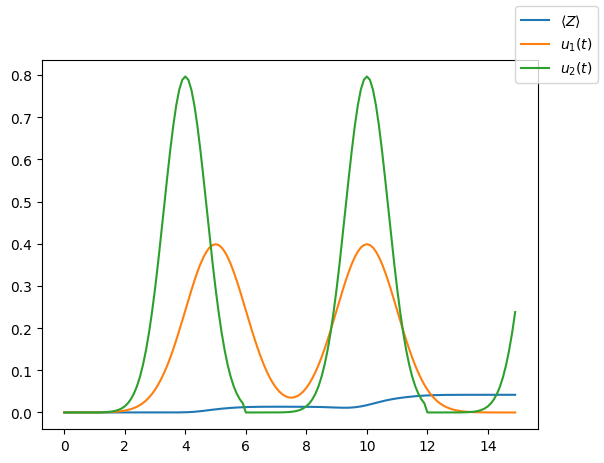

In [7]:
fig, ax = plt.subplots()
controller.plot(
    ax=ax,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"],
)
fig.legend()
fig.show()

#### Training

In [8]:
new_controller = controller.optimize(
    N_steps=40,
    learning_rate=.1,
    verbosity=2,
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.1473674, 1.1473674], dtype=float32),
      mean=Array([ 4.8526335, 10.1473675], dtype=float32),
      sigma=Array([0.85263264, 0.85263264], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.1473675], dtype=float32),
      mean=Array([3.8526325], dtype=float32),
      sigma=Array([0.35263255], dtype=float32),
      period=Array([5.852633], dtype=float32)
    )
  ]
)
Step: 0 Loss: 0.9581018686294556
ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.2758574, 1.2758148], dtype=float32),
      mean=Array([ 4.972589, 10.275687], dtype=float32),
      sigma=Array([0.7242718 , 0.72447205], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.274978], dtype=float32),
      mean=Array([3.7248921], dtype=float32),
      sigma=Array([0.22665541], dtype=float32),
      period=Array([5.9713707], dtype=float32)
    )
  ]
)
Step: 1 Loss: 0.7526382803916931
ControlVector(
  us=[
    GaussianControl(
   

#### Post-Training

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_78938/1590037031.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


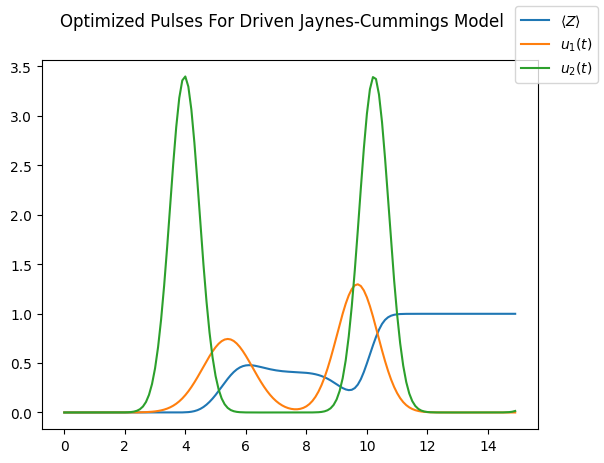

In [9]:
fig_opt, ax_opt = plt.subplots()
new_controller.plot(
    ax_opt,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"]
)
fig_opt.legend()
fig_opt.suptitle("Optimized Pulses For Driven Jaynes-Cummings Model")
fig_opt.show()

### Open System Demos

In [10]:
U_0 = jnp.sqrt(.1)*a
open_sys = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[U_0],
    C_K=[]
)
open_controls = jc_controls

open_controller = OptimalController(
    system=open_sys,
    controls=open_controls,
    y0=dq.todm(psi_0),
    duration=duration,
    y_final=final_penalty
)

#### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_78938/2901399393.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


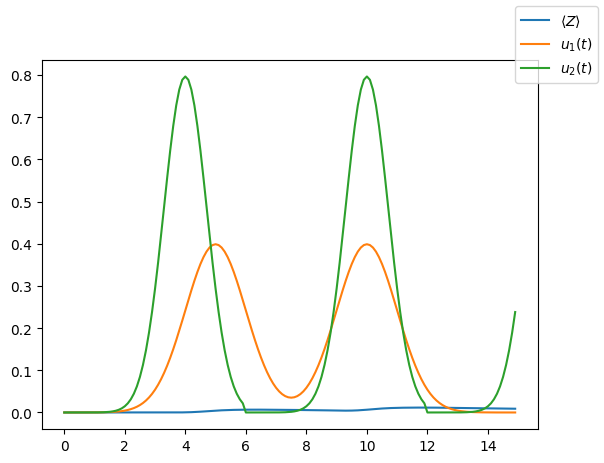

In [11]:
fig_pre, ax_pre = plt.subplots()
open_controller.plot(
    ax=ax_pre,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"],
)
fig_pre.legend()
fig_pre.show()

#### Train

In [12]:
opt_open_controller = open_controller.optimize(
    N_steps=100,
    verbosity=2,
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.1473672, 1.1473672], dtype=float32),
      mean=Array([ 4.8526344, 10.1473675], dtype=float32),
      sigma=Array([0.8526328, 0.8526329], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.1473674], dtype=float32),
      mean=Array([3.852633], dtype=float32),
      sigma=Array([0.35263258], dtype=float32),
      period=Array([5.8526335], dtype=float32)
    )
  ]
)
Step: 0 Loss: 0.9910761713981628
ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.2758425, 1.2758826], dtype=float32),
      mean=Array([ 4.9655952, 10.275258 ], dtype=float32),
      sigma=Array([0.72434795, 0.72430545], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.2750372], dtype=float32),
      mean=Array([3.7246115], dtype=float32),
      sigma=Array([0.22656001], dtype=float32),
      period=Array([5.9685726], dtype=float32)
    )
  ]
)
Step: 1 Loss: 0.9491218328475952
ControlVector(
  us=[
    GaussianControl(
  

#### Post-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_78938/353207557.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


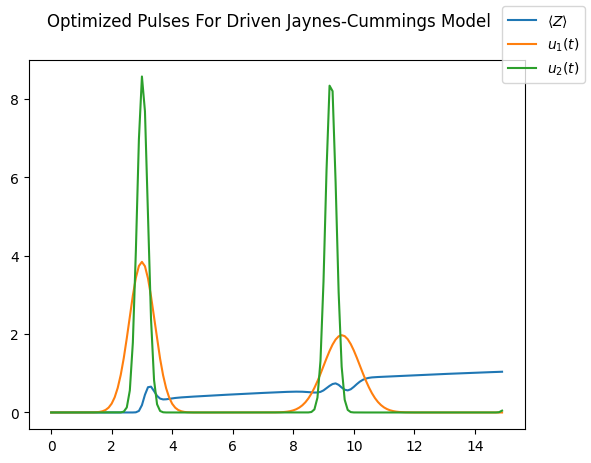

In [13]:
fig_open_opt, ax_open_opt = plt.subplots()
opt_open_controller.plot(
    ax_open_opt,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"]
)
fig_open_opt.legend()
fig_open_opt.suptitle("Optimized Pulses For Driven Jaynes-Cummings Model")
fig_open_opt.show()
